# Deep Learning Algoritmaları ile Fotoğraflardaki Nesneleri Tanıma ve Sınıflandırma Projesi

<IMG src="MicrosoftTeams-image.png" width="750" height="180">
    

### 1. Gerekli kütüphaneleri import ediyoruz.

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

### 2. Datasetimizi (cifar10 verisetini) yüklüyoruz: (Yükleme işlemi için Internet bağlantınızın olması gerekiyor). Eğer bağlantınız yoksa  veri setini Internetten indirip de yükleyebilirsiniz..

In [2]:
(x_train, y_train), (x_test,y_test) = datasets.cifar10.load_data()

In [3]:
# Verilerin class'ını kontrol ediyoruz.
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
# Veri şeklini kontrol edelim.
x_train.shape , y_train.shape , x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

###  3. Train verisinden ilk 36 resmi görüntüleyelim.

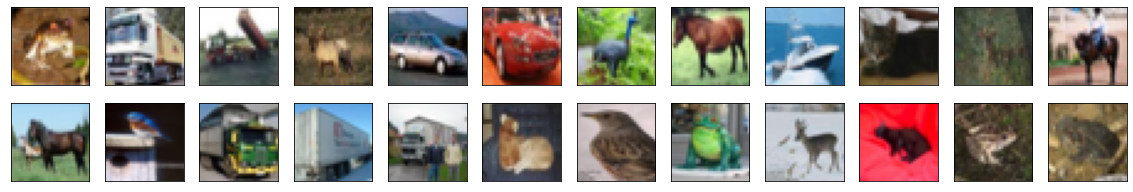

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(24):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 4. Verilere bir göz atalım. Bu amaçla kendimiz bir array oluşturuyoruz: 

In [6]:
resim_siniflari = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [7]:
def plot_sample(x, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(x[index])        
    plt.show()


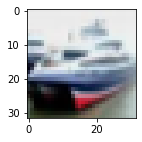

In [8]:
plot_sample(x_test, y_test, 1)

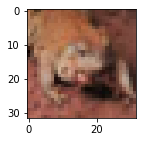

In [9]:
plot_sample(x_test, y_test, 5)

###  5. Normalizasyon
###  Her Görüntüdeki Her Piksel'i 255'e Bölerek Görüntüleri Yeniden Ölçeklendiriyoruz.

Verilerimizi normalize etmemiz gerekiyor. Aksi takdirde CNN algoritmaları yanlış sonuç verebiliyor. Fotoğraflar RGB olarak 3 kanal ve her bir pixel 0-255 arasında değer aldığı için normalization için basitçe her bir pixel değerini 255'e bölmemiz yeterli..

In [10]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 6.  Veri Kümesini Eğitim, Test ve Doğrulama Kümelerine Bölüyoruz.

In [11]:
from keras.utils import np_utils
import tensorflow
from tensorflow.keras.utils import to_categorical

# One Hot Encoding, kategorik verilerin temsilinin daha etkileyici ve kolay olmasını sağlar.
num_classes = len(np.unique(y_train))
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

# Eğitim setini, eğitim ve doğrulama setlerine ayırıyoruz.
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Eğitim setinin şeklini yazdır.
print('x_train shape:', x_train.shape)

# Eğitim, doğrulama ve test görüntülerinin sayısını yazdırıyoruz.
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


###  7. Modelimizi tanımlıyoruz.
#### Bu kısım Convolution layer.. Bu kısımda fotoğraflardan tanımlama yapabilmek için özellikleri çıkarıyoruz...

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# relu en iyi sonucu verdiği için kullanıldı.
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', activation='relu', 
                        input_shape=(32, 32, 3))) # Her bir image (32x32x3) olacak.
model.add(Conv2D(16,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.35))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                        

### 8. Modeli Derliyoruz.

In [13]:
from keras import optimizers
# optimizer öğrenme oranını kontrol eder.
# RMSprop öğrenme oranını bir hiperparametre olarak değerlendirmek yerine uyarlanabilir bir öğrenme oranı kullanır.
RMSprop = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop, 
                  metrics=['accuracy'])

### 9. Modeli Eğitiyoruz.

In [14]:
# batch_size bir seferde eğitilecek örnek sayısı
# epoch Bütün veri kümesinin yapay sinir ağından bir kere geçmesine denir.
# Verbose = 2 -> Her bir epoch sonunda tek bir satır olarak bize çıktı verir.
# Shuffle her bir epochs'tan önce verilerin yerlerinin değiştirilmesi için kullanılır.
hist = model.fit(x_train, y_train, batch_size=32, epochs=80,
        validation_data=(x_valid, y_valid), 
          verbose=2, shuffle=True)

Epoch 1/80
1407/1407 - 44s - loss: 2.1066 - accuracy: 0.1829 - val_loss: 1.8418 - val_accuracy: 0.3192 - 44s/epoch - 32ms/step
Epoch 2/80
1407/1407 - 42s - loss: 1.8394 - accuracy: 0.2920 - val_loss: 1.7154 - val_accuracy: 0.3732 - 42s/epoch - 30ms/step
Epoch 3/80
1407/1407 - 42s - loss: 1.7130 - accuracy: 0.3535 - val_loss: 1.5679 - val_accuracy: 0.4220 - 42s/epoch - 30ms/step
Epoch 4/80
1407/1407 - 43s - loss: 1.6244 - accuracy: 0.3917 - val_loss: 1.5248 - val_accuracy: 0.4386 - 43s/epoch - 31ms/step
Epoch 5/80
1407/1407 - 42s - loss: 1.5655 - accuracy: 0.4182 - val_loss: 1.4548 - val_accuracy: 0.4590 - 42s/epoch - 30ms/step
Epoch 6/80
1407/1407 - 42s - loss: 1.5178 - accuracy: 0.4356 - val_loss: 1.4424 - val_accuracy: 0.4700 - 42s/epoch - 30ms/step
Epoch 7/80
1407/1407 - 40s - loss: 1.4805 - accuracy: 0.4498 - val_loss: 1.4034 - val_accuracy: 0.4848 - 40s/epoch - 29ms/step
Epoch 8/80
1407/1407 - 43s - loss: 1.4408 - accuracy: 0.4690 - val_loss: 1.4459 - val_accuracy: 0.4856 - 43s/ep

1407/1407 - 39s - loss: 0.9085 - accuracy: 0.6892 - val_loss: 0.8231 - val_accuracy: 0.7368 - 39s/epoch - 28ms/step
Epoch 66/80
1407/1407 - 39s - loss: 0.9011 - accuracy: 0.6902 - val_loss: 0.7968 - val_accuracy: 0.7396 - 39s/epoch - 28ms/step
Epoch 67/80
1407/1407 - 39s - loss: 0.9024 - accuracy: 0.6911 - val_loss: 0.7948 - val_accuracy: 0.7374 - 39s/epoch - 28ms/step
Epoch 68/80
1407/1407 - 39s - loss: 0.9011 - accuracy: 0.6922 - val_loss: 0.7768 - val_accuracy: 0.7436 - 39s/epoch - 28ms/step
Epoch 69/80
1407/1407 - 39s - loss: 0.8987 - accuracy: 0.6931 - val_loss: 0.7830 - val_accuracy: 0.7398 - 39s/epoch - 28ms/step
Epoch 70/80
1407/1407 - 39s - loss: 0.8971 - accuracy: 0.6944 - val_loss: 0.8181 - val_accuracy: 0.7248 - 39s/epoch - 28ms/step
Epoch 71/80
1407/1407 - 39s - loss: 0.8915 - accuracy: 0.6934 - val_loss: 0.7879 - val_accuracy: 0.7326 - 39s/epoch - 28ms/step
Epoch 72/80
1407/1407 - 39s - loss: 0.8891 - accuracy: 0.6976 - val_loss: 0.8062 - val_accuracy: 0.7368 - 39s/epoch 

### 10. Test setindeki doğruluğu hesaplıyoruz.

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7138000130653381


### 11. Accuracy değelerini grafikler üzerinde gösteriyoruz.

<ipython-input-16-dc0fedbe7238>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len_acc + 1), len_acc / 10)
<ipython-input-16-dc0fedbe7238>:30: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len_loss + 1), len_loss / 10)


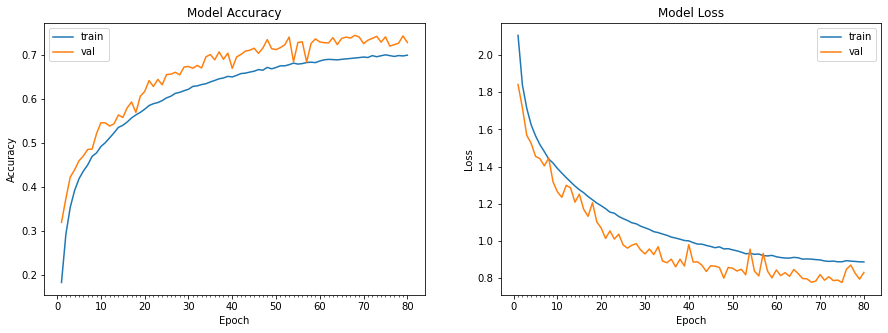

In [16]:
# Accuracy grafiği oluşturmak için değer atıyoruz.
acc = hist.history['accuracy'] 
val_acc =  hist.history['val_accuracy'] 
loss = hist.history['loss'] 
val_loss = hist.history['val_loss'] 

len_acc = len(acc) 
len_val_acc = len(val_acc)
len_loss = len(loss)
len_val_loss = len(val_loss)

# Sonuçları görüntülüyoruz.
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy değeri
axs[0].plot(range(1, len_acc + 1), acc)
axs[0].plot(range(1, len_val_acc + 1), val_acc)
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1, len_acc + 1), len_acc / 10)
axs[0].legend(['train', 'val'], loc='best')

# Loss değeri
axs[1].plot(range(1, len_loss +1), loss)
axs[1].plot(range(1, len_val_loss +1), val_loss)
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1, len_loss + 1), len_loss / 10)
axs[1].legend(['train', 'val'], loc='best')
plt.show()

### 12. Bazı tahminleri görselleştiriyoruz. 



In [17]:
# Test setinden tahminleri alıyoruz.
y_hat = model.predict(x_test)

# Metin etikelerini tanımlıyoruz. 
cifar10_labels = ['Uçak', 'Otomobil', 'Kuş', 'Kedi', 'Geyik', 'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyonet']

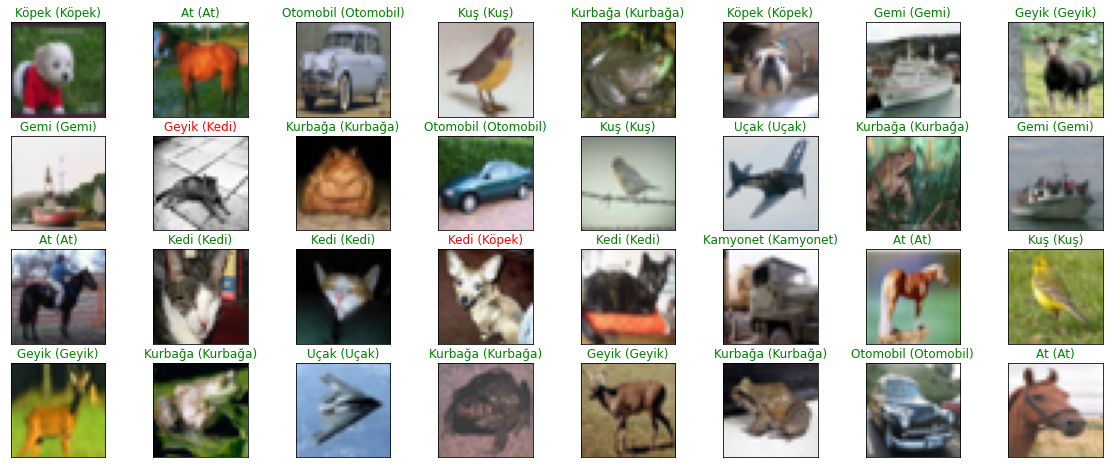

In [18]:
# Bu kısımda rastgele bir test görüntüsü örneği, tahmin edilen etiketler ve temel gerçeği çizin
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))